In [1]:
# ===================================================================
# PIPELINE : Two Layer LSTM -> TabNet -> Ridge
# TARGET: Minimize RMSE and SMAPE for IHSG Closing Price Prediction
# ===================================================================

# -------------------
# 1. Imports & Config
# -------------------
import yfinance as yf
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import optuna
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
import torch
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Attention, Input, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from pytorch_tabnet.metrics import Metric # Import Metric class
import shap

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
tf.random.set_seed(42)
np.random.seed(42)
torch.manual_seed(42)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# ---------------------
# 2. Data Preparation
# ---------------------
print("--- Loading and Preparing Data ---")
start_date = "2010-01-01"
end_date = datetime.now().strftime('%Y-%m-%d')

variables = {
    "IHSG": "^JKSE", "S&P 500": "^GSPC", "Nasdaq": "^IXIC", "VIX": "^VIX",
    "Hang Seng Index": "^HSI", "Crude Oil (WTI)": "CL=F", "Gold": "GC=F",
    "USD/IDR": "IDR=X", "DAX": "^GDAXI", "Crude Oil (Brent)": "BZ=F",
    "EUR/USD": "EURUSD=X", "Copper": "HG=F", "Silver": "SI=F"
}
data_ohlc = yf.download(list(variables.values()), start=start_date, end=end_date, auto_adjust=False)

# --- RESEARCH STEP 1: Isolate, Show, and Export Raw IHSG Data ---
ihsg_raw_df = data_ohlc.loc[:, (slice(None), '^JKSE')]
ihsg_raw_df.columns = ihsg_raw_df.columns.droplevel(1)
ihsg_raw_df.dropna(inplace=True)

print("\n--- Raw IHSG Data Snapshot (Tabel 1. Data IHSG) ---")
print(ihsg_raw_df.head().reset_index().to_string())
print(f"\n{len(ihsg_raw_df)} rows x {len(ihsg_raw_df.columns)} columns")
ihsg_raw_df.to_csv('raw_ihsg_data_tabnet.csv')
print("Raw IHSG OHLCVA data exported to 'raw_ihsg_data_tabnet.csv'")

# --- Continue with the full dataset for feature engineering ---
data = data_ohlc['Close'].copy()
volume = data_ohlc['Volume'].copy()
data.rename(columns={v: k for k, v in variables.items()}, inplace=True)
volume.rename(columns={v: f"{k}_Volume" for k, v in variables.items()}, inplace=True)


try:
    fed_rate = web.DataReader('FEDFUNDS', 'fred', start=start_date, end=end_date)
    data = data.join(fed_rate)
    data.rename(columns={'FEDFUNDS': 'Federal Funds Rate (Effective)'}, inplace=True)
    variables["Federal Funds Rate (Effective)"] = "Federal Funds Rate (Effective)"
except Exception as e:
    print(f"Could not fetch FEDFUNDS data. Error: {e}")

data = data.join(volume)
data.dropna(axis=1, how='all', inplace=True)
data = data.ffill().bfill()

# --- Feature Engineering ---
print("\n--- Performing Advanced Feature Engineering ---")

# --- TECHNICAL INDICATORS (Manual Calculation) ---
exp1 = data['IHSG'].ewm(span=12, adjust=False).mean()
exp2 = data['IHSG'].ewm(span=26, adjust=False).mean()
data['MACD_12_26_9'] = exp1 - exp2
data['MACDs_12_26_9'] = data['MACD_12_26_9'].ewm(span=9, adjust=False).mean()
data['MACDh_12_26_9'] = data['MACD_12_26_9'] - data['MACDs_12_26_9']
delta = data['IHSG'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI_14'] = 100 - (100 / (1 + rs))
data['BBM_20_2.0'] = data['IHSG'].rolling(window=20).mean()
std_dev = data['IHSG'].rolling(window=20).std()
data['BBU_20_2.0'] = data['BBM_20_2.0'] + (std_dev * 2)
data['BBL_20_2.0'] = data['BBM_20_2.0'] - (std_dev * 2)

# --- ENGINEERED FEATURES & TIME-BASED FEATURES ---
for col in variables.keys():
    if col != 'IHSG' and col in data.columns:
        for lag in [1, 2, 3, 5, 10, 21]:
            data[f'{col}_pct_change_{lag}d'] = data[col].pct_change(lag)

data['Gold_vs_SP500'] = data['Gold'] / data['S&P 500']
data['DayOfWeek'] = data.index.dayofweek
data['Month'] = data.index.month
data['WeekOfYear'] = data.index.isocalendar().week.astype(int)
data['DayOfYear'] = data.index.dayofyear
data.dropna(inplace=True)

# --- RESEARCH STEP 2: Show and Export Featured Data ---
print("\n--- Featured Data Snapshot ---")
print(data.head())
data.to_csv('featured_data_tabnet.csv')
print("Featured data exported to 'featured_data_tabnet.csv'")

# ---------------------------
# 3. Data for Price Prediction
# ---------------------------
data['Target'] = data['IHSG'].shift(-1)
data.dropna(inplace=True)

features = [col for col in data.columns if col not in ['Target', 'IHSG']]
X = data[features]
y = data['Target']

categorical_cols = ['DayOfWeek', 'Month', 'WeekOfYear', 'DayOfYear']
categorical_idxs = [features.index(col) for col in categorical_cols]
categorical_dims = [len(X[col].unique()) for col in categorical_cols]

train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"\nTotal data rows after feature engineering and cleaning: {len(X)}")
print(f"Total training data rows: {len(X_train)}")
print(f"Total test data rows: {len(X_test)}")

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))

# --- RESEARCH STEP 3: Show Scaled Data ---
print("\n--- Scaled Training Data Snapshot (First 5 Rows) ---")
print(X_train_scaled[:5])

/home/rangga/metopen/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-18 08:21:40.848680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752801701.007344   13443 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752801701.055489   13443 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752801701.408923   13443 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0

--- Loading and Preparing Data ---


[*********************100%***********************]  13 of 13 completed



--- Raw IHSG Data Snapshot (Tabel 1. Data IHSG) ---
Price       Date    Adj Close        Close         High          Low         Open      Volume
0     2010-01-04  2575.312988  2575.413086  2576.055908  2532.895996  2533.947998  18339300.0
1     2010-01-05  2605.175537  2605.277100  2606.069092  2575.616943  2575.616943  57043800.0
2     2010-01-06  2603.195557  2603.297119  2622.115967  2587.709961  2605.480957  51569100.0
3     2010-01-07  2586.794189  2586.895020  2611.603027  2570.272949  2603.500977  45510800.0
4     2010-01-08  2614.268311  2614.370117  2614.535889  2583.846924  2586.792969  73723500.0

3771 rows x 6 columns
Raw IHSG OHLCVA data exported to 'raw_ihsg_data_tabnet.csv'

--- Performing Advanced Feature Engineering ---

--- Featured Data Snapshot ---
            Crude Oil (Brent)  Crude Oil (WTI)   EUR/USD         Gold  Copper  \
Date                                                                            
2010-02-01          73.110001        74.430000  1.392699 

In [ ]:
# %%
# -----------------------------------
# 4. Improved LSTM Model (Enhanced)
# -----------------------------------
print("\n--- Training Improved LSTM Model ---")

# Feature selection for LSTM
from sklearn.feature_selection import SelectKBest, f_regression

def create_sequences(X, y, time_steps):
    """
    Create sequences for LSTM training
    
    Parameters:
    X: Input features (2D array)
    y: Target values (1D array)
    time_steps: Number of time steps to look back
    
    Returns:
    X_seq: 3D array of shape (samples, time_steps, features)
    y_seq: 1D array of target values
    """
    X_seq, y_seq = [], []
    
    for i in range(time_steps, len(X)):
        X_seq.append(X[i-time_steps:i])
        y_seq.append(y[i])
    
    return np.array(X_seq), np.array(y_seq)

def select_best_features_lstm(X_train, y_train, features, k=30):
    """Select top k features for LSTM"""
    selector = SelectKBest(score_func=f_regression, k=k)
    X_selected = selector.fit_transform(X_train, y_train)
    selected_features = [features[i] for i in selector.get_support(indices=True)]
    return X_selected, selected_features, selector

# Select best features for LSTM
X_train_selected, selected_features_lstm, feature_selector = select_best_features_lstm(
    X_train_scaled, y_train_scaled.ravel(), features, k=30
)
X_test_selected = feature_selector.transform(X_test_scaled)

print(f"Selected {len(selected_features_lstm)} features for LSTM")

# Find optimal sequence length
def find_optimal_time_steps(X_train, y_train, test_lengths=[20, 40, 60, 80]):
    """Find optimal sequence length"""
    best_score = float('inf')
    best_length = 60
    
    for length in test_lengths:
        if len(X_train) <= length:
            continue
            
        X_seq, y_seq = create_sequences(X_train, y_train, length)
        if len(X_seq) < 200:
            continue
            
        # Quick test model
        inputs = Input(shape=(X_seq.shape[1], X_seq.shape[2]))
        x = LSTM(100)(inputs)
        x = Dropout(0.2)(x)
        outputs = Dense(1)(x)
        test_model = Model(inputs=inputs, outputs=outputs)
        test_model.compile(optimizer=Adam(0.001), loss='mse')
        
        history = test_model.fit(
            X_seq[:800], y_seq[:800], epochs=15, batch_size=32,
            validation_split=0.2, verbose=2,
            callbacks=[EarlyStopping(patience=5)]
        )
        
        val_loss = min(history.history['val_loss'])
        if val_loss < best_score:
            best_score = val_loss
            best_length = length
            
        del test_model
        tf.keras.backend.clear_session()
    
    return best_length

# Find optimal TIME_STEPS
optimal_time_steps = find_optimal_time_steps(X_train_selected, y_train_scaled)
TIME_STEPS = optimal_time_steps
print(f"Optimal TIME_STEPS: {TIME_STEPS}")

# Create sequences with optimal length
X_train_seq, y_train_seq = create_sequences(X_train_selected, y_train_scaled, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test_selected, y_test_scaled, TIME_STEPS)

# Walk-forward validation for hyperparameter tuning
def walk_forward_splits(X, y, n_splits=3):
    """Create walk-forward validation splits"""
    n_samples = len(X)
    min_train_size = int(n_samples * 0.6)
    step_size = (n_samples - min_train_size) // n_splits
    
    splits = []
    for i in range(n_splits):
        train_end = min_train_size + (i * step_size)
        test_start = train_end
        test_end = min(train_end + step_size, n_samples)
        
        if test_end > n_samples or test_start >= test_end:
            break
            
        splits.append((np.arange(0, train_end), np.arange(test_start, test_end)))
    
    return splits

def objective_lstm(trial):
    # Enhanced hyperparameters
    units1 = trial.suggest_categorical('units1', [128, 256, 512])
    units2 = trial.suggest_categorical('units2', [64, 128, 256])
    dropout1 = trial.suggest_float('dropout1', 0.1, 0.3)
    dropout2 = trial.suggest_float('dropout2', 0.1, 0.3)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    
    # Walk-forward validation
    splits = walk_forward_splits(X_train_seq, y_train_seq)
    fold_scores = []
    
    for train_idx, val_idx in splits:
        # Create model for this fold
        inputs = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
        x = LSTM(units1, return_sequences=True, 
                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5))(inputs)
        
        if use_batch_norm:
            x = BatchNormalization()(x)
        x = Dropout(dropout1)(x)
        
        x = LSTM(units2, return_sequences=False,
                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5))(x)
        
        if use_batch_norm:
            x = BatchNormalization()(x)
        x = Dropout(dropout2)(x)
        
        outputs = Dense(1)(x)
        model = Model(inputs=inputs, outputs=outputs)
        
        # Use Huber loss for robustness
        model.compile(optimizer=Adam(lr), loss=tf.keras.losses.Huber(delta=1.0))
        
        # Train on fold
        X_fold_train = X_train_seq[train_idx]
        y_fold_train = y_train_seq[train_idx]
        X_fold_val = X_train_seq[val_idx]
        y_fold_val = y_train_seq[val_idx]
        
        history = model.fit(
            X_fold_train, y_fold_train,
            validation_data=(X_fold_val, y_fold_val),
            epochs=50, batch_size=batch_size, verbose=2,
            callbacks=[
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
            ]
        )
        
        val_loss = min(history.history['val_loss'])
        fold_scores.append(val_loss)
        
        del model
        tf.keras.backend.clear_session()
    
    mean_score = np.mean(fold_scores)
    print(f"  Trial {trial.number} CV score: {mean_score:.6f}")
    return mean_score

# Hyperparameter optimization with walk-forward validation
study_lstm = optuna.create_study(direction='minimize')
study_lstm.optimize(objective_lstm, n_trials=20)
best_lstm_params = study_lstm.best_params
print(f"\nBest Params Found ===> {best_lstm_params}")



--- Training Improved LSTM Model ---
Selected 30 features for LSTM
Epoch 1/15


2025-07-18 08:21:49.413697: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


20/20 - 2s - 91ms/step - loss: 0.0224 - val_loss: 0.0028
Epoch 2/15
20/20 - 3s - 165ms/step - loss: 0.0062 - val_loss: 0.0011
Epoch 3/15
20/20 - 0s - 17ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 4/15
20/20 - 0s - 18ms/step - loss: 0.0027 - val_loss: 0.0022
Epoch 5/15
20/20 - 0s - 18ms/step - loss: 0.0023 - val_loss: 7.0554e-04
Epoch 6/15
20/20 - 0s - 16ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 7/15
20/20 - 0s - 17ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 8/15
20/20 - 0s - 16ms/step - loss: 0.0012 - val_loss: 7.9853e-04
Epoch 9/15
20/20 - 0s - 17ms/step - loss: 0.0013 - val_loss: 6.0022e-04
Epoch 10/15
20/20 - 0s - 17ms/step - loss: 9.1248e-04 - val_loss: 8.2197e-04
Epoch 11/15
20/20 - 0s - 17ms/step - loss: 9.1396e-04 - val_loss: 6.9305e-04
Epoch 12/15
20/20 - 0s - 17ms/step - loss: 8.0848e-04 - val_loss: 0.0011
Epoch 13/15
20/20 - 0s - 17ms/step - loss: 9.8363e-04 - val_loss: 0.0010
Epoch 14/15
20/20 - 0s - 16ms/step - loss: 9.1435e-04 - val_loss: 0.0011
Epoch 1/15
20

Epoch 1/150
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0683 - mae: 0.1546 - mse: 0.0861

171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 0.0679 - mae: 0.1537 - mse: 0.0854 - val_loss: 0.0207 - val_mae: 0.0840 - val_mse: 0.0107 - learning_rate: 0.0052
Epoch 2/150
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0146 - mae: 0.0416 - mse: 0.0029

171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0146 - mae: 0.0416 - mse: 0.0029 - val_loss: 0.0112 - val_mae: 0.0573 - val_mse: 0.0055 - learning_rate: 0.0052
Epoch 3/150
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0088 - mae: 0.0395 - mse: 0.0026

171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0088 - mae: 0.0395 - mse: 0.0026 - val_loss: 0.0096 - val_mae: 0.0752 - val_mse: 0.0086 - learning_rate: 0.0052
Epoch 4/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0059 - mae: 0.0358 - mse: 0.0021

171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0059 - mae: 0.0358 - mse: 0.0021 - val_loss: 0.0069 - val_mae: 0.0615 - val_mse: 0.0064 - learning_rate: 0.0052
Epoch 5/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0044 - mae: 0.0352 - mse: 0.0021 - val_loss: 0.0080 - val_mae: 0.0841 - val_mse: 0.0107 - learning_rate: 0.0052
Epoch 6/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0035 - mae: 0.0352 - mse: 0.0021

171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0035 - mae: 0.0351 - mse: 0.0021 - val_loss: 0.0066 - val_mae: 0.0788 - val_mse: 0.0093 - learning_rate: 0.0052
Epoch 7/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0029 - mae: 0.0357 - mse: 0.0021 - val_loss: 0.0070 - val_mae: 0.0866 - val_mse: 0.0110 - learning_rate: 0.0052
Epoch 8/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0024 - mae: 0.0332 - mse: 0.0018

171/171 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0024 - mae: 0.0332 - mse: 0.0018 - val_loss: 0.0058 - val_mae: 0.0788 - val_mse: 0.0092 - learning_rate: 0.0052
Epoch 9/150
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0019 - mae: 0.0303 - mse: 0.0016

171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0019 - mae: 0.0303 - mse: 0.0016 - val_loss: 0.0034 - val_mae: 0.0522 - val_mse: 0.0048 - learning_rate: 0.0052
Epoch 10/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0017 - mae: 0.0303 - mse: 0.0015 - val_loss: 0.0100 - val_mae: 0.1190 - val_mse: 0.0183 - learning_rate: 0.0052
Epoch 11/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0019 - mae: 0.0347 - mse: 0.0020 - val_loss: 0.0034 - val_mae: 0.0551 - val_mse: 0.0053 - learning_rate: 0.0052
Epoch 12/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.0015 - mae: 0.0303 - mse: 0.0015 - val_loss: 0.0041 - val_mae: 0.0639 - val_mse: 0.0067 - learning_rate: 0.0052
Epoch 13/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0015 - mae: 0.0307 - mse: 0.0016

171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0015 - mae: 0.0307 - mse: 0.0016 - val_loss: 0.0030 - val_mae: 0.0519 - val_mse: 0.0047 - learning_rate: 0.0052
Epoch 14/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0014 - mae: 0.0294 - mse: 0.0015 - val_loss: 0.0034 - val_mae: 0.0578 - val_mse: 0.0056 - learning_rate: 0.0052
Epoch 15/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0013 - mae: 0.0292 - mse: 0.0014 - val_loss: 0.0054 - val_mae: 0.0797 - val_mse: 0.0095 - learning_rate: 0.0052
Epoch 16/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0011 - mae: 0.0254 - mse: 0.0011 - val_loss: 0.0046 - val_mae: 0.0726 - val_mse: 0.0081 - learning_rate: 0.0052
Epoch 17/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0014 - mae: 0.0303 - mse: 0.0015 - val_loss: 0.0044 - val_mae: 0.0714 - val_mse: 0.0078 - learning_rate: 0.0052
Epoch 18/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0012 - mae: 0.0265 - mse: 0.0012 - val_loss: 0.0044 - val_mae: 

171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 8.1616e-04 - mae: 0.0219 - mse: 8.3082e-04 - val_loss: 0.0030 - val_mae: 0.0577 - val_mse: 0.0052 - learning_rate: 0.0026
Epoch 25/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 7.5454e-04 - mae: 0.0213 - mse: 7.8015e-04 - val_loss: 0.0038 - val_mae: 0.0681 - val_mse: 0.0069 - learning_rate: 0.0026
Epoch 26/150
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.4213e-04 - mae: 0.0210 - mse: 7.6859e-04

171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 7.4197e-04 - mae: 0.0210 - mse: 7.6844e-04 - val_loss: 0.0030 - val_mae: 0.0574 - val_mse: 0.0052 - learning_rate: 0.0026
Epoch 27/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.2016e-04 - mae: 0.0220 - mse: 8.8098e-04

171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 8.1995e-04 - mae: 0.0220 - mse: 8.8074e-04 - val_loss: 0.0028 - val_mae: 0.0563 - val_mse: 0.0050 - learning_rate: 0.0026
Epoch 28/150
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.2042e-04 - mae: 0.0226 - mse: 8.9106e-04

171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 8.1967e-04 - mae: 0.0226 - mse: 8.8998e-04 - val_loss: 0.0027 - val_mae: 0.0548 - val_mse: 0.0047 - learning_rate: 0.0026
Epoch 29/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 7.3969e-04 - mae: 0.0210 - mse: 7.7607e-04 - val_loss: 0.0034 - val_mae: 0.0649 - val_mse: 0.0060 - learning_rate: 0.0026
Epoch 30/150
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7.6501e-04 - mae: 0.0220 - mse: 8.1350e-04

171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 7.6463e-04 - mae: 0.0220 - mse: 8.1295e-04 - val_loss: 0.0023 - val_mae: 0.0501 - val_mse: 0.0040 - learning_rate: 0.0026
Epoch 31/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 7.6976e-04 - mae: 0.0217 - mse: 8.1333e-04 - val_loss: 0.0027 - val_mae: 0.0560 - val_mse: 0.0047 - learning_rate: 0.0026
Epoch 32/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 7.1908e-04 - mae: 0.0212 - mse: 7.3910e-04 - val_loss: 0.0035 - val_mae: 0.0670 - val_mse: 0.0063 - learning_rate: 0.0026
Epoch 33/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 7.7032e-04 - mae: 0.0212 - mse: 8.1029e-04 - val_loss: 0.0025 - val_mae: 0.0527 - val_mse: 0.0042 - learning_rate: 0.0026
Epoch 34/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 7.0819e-04 - mae: 0.0206 - mse: 7.2569e-04 - val_loss: 0.0027 - val_mae: 0.0560 - val_mse: 0.0048 - learning_rate: 0.0026
Epoch 35/150
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8.4300e-04 - mae: 0.0229 

171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 8.4232e-04 - mae: 0.0229 - mse: 9.1485e-04 - val_loss: 0.0022 - val_mae: 0.0497 - val_mse: 0.0037 - learning_rate: 0.0026
Epoch 36/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 7.4618e-04 - mae: 0.0214 - mse: 7.8888e-04 - val_loss: 0.0028 - val_mae: 0.0567 - val_mse: 0.0048 - learning_rate: 0.0026
Epoch 37/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 7.6725e-04 - mae: 0.0219 - mse: 8.1698e-04 - val_loss: 0.0022 - val_mae: 0.0484 - val_mse: 0.0037 - learning_rate: 0.0026
Epoch 38/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.2323e-04 - mae: 0.0207 - mse: 7.4149e-04

171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 7.2317e-04 - mae: 0.0207 - mse: 7.4148e-04 - val_loss: 0.0022 - val_mae: 0.0475 - val_mse: 0.0036 - learning_rate: 0.0026
Epoch 39/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 8.0537e-04 - mae: 0.0222 - mse: 8.5910e-04 - val_loss: 0.0026 - val_mae: 0.0551 - val_mse: 0.0045 - learning_rate: 0.0026
Epoch 40/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 7.7678e-04 - mae: 0.0220 - mse: 8.3001e-04 - val_loss: 0.0023 - val_mae: 0.0512 - val_mse: 0.0040 - learning_rate: 0.0026
Epoch 41/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 7.7215e-04 - mae: 0.0217 - mse: 8.1494e-04 - val_loss: 0.0022 - val_mae: 0.0506 - val_mse: 0.0038 - learning_rate: 0.0026
Epoch 42/150
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 7.6038e-04 - mae: 0.0216 - mse: 7.8866e-04

171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 7.5996e-04 - mae: 0.0216 - mse: 7.8818e-04 - val_loss: 0.0016 - val_mae: 0.0403 - val_mse: 0.0026 - learning_rate: 0.0026
Epoch 43/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 7.6975e-04 - mae: 0.0222 - mse: 8.1807e-04 - val_loss: 0.0017 - val_mae: 0.0415 - val_mse: 0.0028 - learning_rate: 0.0026
Epoch 44/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.9328e-04 - mae: 0.0201 - mse: 7.0794e-04 - val_loss: 0.0021 - val_mae: 0.0497 - val_mse: 0.0036 - learning_rate: 0.0026
Epoch 45/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 7.6305e-04 - mae: 0.0220 - mse: 8.1563e-04 - val_loss: 0.0024 - val_mae: 0.0530 - val_mse: 0.0040 - learning_rate: 0.0026
Epoch 46/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 7.4522e-04 - mae: 0.0217 - mse: 7.7898e-04 - val_loss: 0.0021 - val_mae: 0.0494 - val_mse: 0.0035 - learning_rate: 0.0026
Epoch 47/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 7.2150e-04 - mae: 0.0210 

171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 7.4945e-04 - mae: 0.0214 - mse: 7.7966e-04 - val_loss: 0.0013 - val_mae: 0.0351 - val_mse: 0.0020 - learning_rate: 0.0026
Epoch 51/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 6.8359e-04 - mae: 0.0204 - mse: 7.0940e-04 - val_loss: 0.0017 - val_mae: 0.0420 - val_mse: 0.0027 - learning_rate: 0.0026
Epoch 52/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.5152e-04 - mae: 0.0192 - mse: 6.2752e-04 - val_loss: 0.0021 - val_mae: 0.0512 - val_mse: 0.0037 - learning_rate: 0.0026
Epoch 53/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 6.2837e-04 - mae: 0.0192 - mse: 6.3107e-04 - val_loss: 0.0024 - val_mae: 0.0540 - val_mse: 0.0041 - learning_rate: 0.0026
Epoch 54/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 7.4873e-04 - mae: 0.0214 - mse: 7.9299e-04

171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 7.4866e-04 - mae: 0.0214 - mse: 7.9278e-04 - val_loss: 0.0011 - val_mae: 0.0292 - val_mse: 0.0014 - learning_rate: 0.0026
Epoch 55/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 6.9201e-04 - mae: 0.0199 - mse: 6.8890e-04 - val_loss: 0.0013 - val_mae: 0.0352 - val_mse: 0.0020 - learning_rate: 0.0026
Epoch 56/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 6.2499e-04 - mae: 0.0187 - mse: 6.1605e-04 - val_loss: 0.0012 - val_mae: 0.0331 - val_mse: 0.0017 - learning_rate: 0.0026
Epoch 57/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 6.4303e-04 - mae: 0.0197 - mse: 6.5373e-04

171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 6.4306e-04 - mae: 0.0197 - mse: 6.5376e-04 - val_loss: 8.6375e-04 - val_mae: 0.0258 - val_mse: 0.0011 - learning_rate: 0.0026
Epoch 58/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 6.3958e-04 - mae: 0.0191 - mse: 6.3218e-04 - val_loss: 0.0021 - val_mae: 0.0509 - val_mse: 0.0035 - learning_rate: 0.0026
Epoch 59/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 6.9329e-04 - mae: 0.0202 - mse: 6.9921e-04 - val_loss: 8.8433e-04 - val_mae: 0.0258 - val_mse: 0.0011 - learning_rate: 0.0026
Epoch 60/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 6.9521e-04 - mae: 0.0208 - mse: 7.1958e-04 - val_loss: 0.0018 - val_mae: 0.0469 - val_mse: 0.0031 - learning_rate: 0.0026
Epoch 61/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 7.1188e-04 - mae: 0.0210 - mse: 7.5381e-04 - val_loss: 0.0014 - val_mae: 0.0370 - val_mse: 0.0021 - learning_rate: 0.0026
Epoch 62/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 6.7431e-04 - mae:

171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 5.8844e-04 - mae: 0.0183 - mse: 5.7486e-04 - val_loss: 8.3183e-04 - val_mae: 0.0253 - val_mse: 0.0010 - learning_rate: 0.0026
Epoch 67/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 6.6916e-04 - mae: 0.0200 - mse: 6.7937e-04 - val_loss: 0.0011 - val_mae: 0.0322 - val_mse: 0.0016 - learning_rate: 0.0026
Epoch 68/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 5.1096e-04 - mae: 0.0182 - mse: 5.7800e-04 - val_loss: 8.8506e-04 - val_mae: 0.0299 - val_mse: 0.0014 - learning_rate: 0.0013
Epoch 69/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 4.6915e-04 - mae: 0.0174 - mse: 5.4210e-04 - val_loss: 0.0012 - val_mae: 0.0361 - val_mse: 0.0019 - learning_rate: 0.0013
Epoch 70/150
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.4327e-04 - mae: 0.0174 - mse: 5.0828e-04

171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 4.4337e-04 - mae: 0.0174 - mse: 5.0848e-04 - val_loss: 8.2135e-04 - val_mae: 0.0281 - val_mse: 0.0013 - learning_rate: 0.0013
Epoch 71/150
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.3840e-04 - mae: 0.0167 - mse: 4.9398e-04

171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 4.3839e-04 - mae: 0.0167 - mse: 4.9398e-04 - val_loss: 8.0257e-04 - val_mae: 0.0275 - val_mse: 0.0012 - learning_rate: 0.0013
Epoch 72/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 4.6925e-04 - mae: 0.0179 - mse: 5.5926e-04 - val_loss: 8.3600e-04 - val_mae: 0.0287 - val_mse: 0.0013 - learning_rate: 0.0013
Epoch 73/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 4.6429e-04 - mae: 0.0174 - mse: 5.3791e-04 - val_loss: 8.5806e-04 - val_mae: 0.0289 - val_mse: 0.0013 - learning_rate: 0.0013
Epoch 74/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 4.5424e-04 - mae: 0.0171 - mse: 5.2550e-04 - val_loss: 0.0010 - val_mae: 0.0321 - val_mse: 0.0016 - learning_rate: 0.0013
Epoch 75/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 4.9730e-04 - mae: 0.0178 - mse: 5.7460e-04 - val_loss: 0.0010 - val_mae: 0.0332 - val_mse: 0.0017 - learning_rate: 0.0013
Epoch 76/150
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 4.4619e-04 - 

171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 4.4596e-04 - mae: 0.0169 - mse: 5.1483e-04 - val_loss: 6.0000e-04 - val_mae: 0.0216 - val_mse: 8.0398e-04 - learning_rate: 0.0013
Epoch 77/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 4.9767e-04 - mae: 0.0185 - mse: 5.9450e-04 - val_loss: 6.4911e-04 - val_mae: 0.0235 - val_mse: 9.3987e-04 - learning_rate: 0.0013
Epoch 78/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 4.9546e-04 - mae: 0.0184 - mse: 6.0996e-04 - val_loss: 6.9188e-04 - val_mae: 0.0247 - val_mse: 9.9048e-04 - learning_rate: 0.0013
Epoch 79/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 4.4787e-04 - mae: 0.0172 - mse: 5.1725e-04 - val_loss: 8.6724e-04 - val_mae: 0.0289 - val_mse: 0.0013 - learning_rate: 0.0013
Epoch 80/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 4.7633e-04 - mae: 0.0178 - mse: 5.6306e-04 - val_loss: 8.6725e-04 - val_mae: 0.0295 - val_mse: 0.0013 - learning_rate: 0.0013
Epoch 81/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step -

171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 3.4452e-04 - mae: 0.0159 - mse: 4.3540e-04 - val_loss: 5.7892e-04 - val_mae: 0.0234 - val_mse: 9.0833e-04 - learning_rate: 6.5089e-04
Epoch 90/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 3.6486e-04 - mae: 0.0162 - mse: 4.6821e-04 - val_loss: 6.8564e-04 - val_mae: 0.0259 - val_mse: 0.0011 - learning_rate: 6.5089e-04
Epoch 91/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 3.3307e-04 - mae: 0.0157 - mse: 4.1627e-04 - val_loss: 8.5123e-04 - val_mae: 0.0305 - val_mse: 0.0015 - learning_rate: 6.5089e-04
Epoch 92/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 3.5492e-04 - mae: 0.0163 - mse: 4.5798e-04 - val_loss: 7.9972e-04 - val_mae: 0.0290 - val_mse: 0.0014 - learning_rate: 6.5089e-04
Epoch 93/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 3.4469e-04 - mae: 0.0158 - mse: 4.4140e-04 - val_loss: 8.2258e-04 - val_mae: 0.0296 - val_mse: 0.0014 - learning_rate: 6.5089e-04
Epoch 94/150
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s

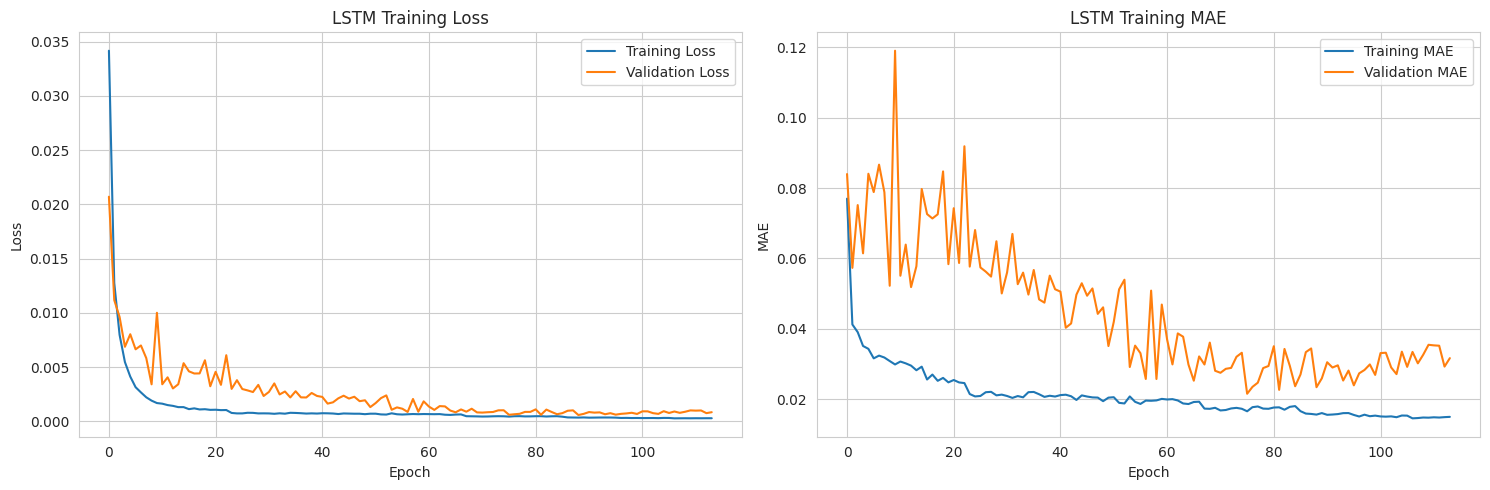

LSTM model trained with 30 features and 20 time steps


In [3]:
# Build final model with enhancements
inputs = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
x = LSTM(best_lstm_params['units1'], return_sequences=True,
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5))(inputs)

if best_lstm_params.get('use_batch_norm', False):
    x = BatchNormalization()(x)
x = Dropout(best_lstm_params['dropout1'])(x)

x = LSTM(best_lstm_params['units2'], return_sequences=False,
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-5))(x)

if best_lstm_params.get('use_batch_norm', False):
    x = BatchNormalization()(x)
x = Dropout(best_lstm_params['dropout2'])(x)

outputs = Dense(1)(x)
final_lstm = Model(inputs=inputs, outputs=outputs)

# Enhanced compilation and training
final_lstm.compile(
    optimizer=Adam(best_lstm_params['lr']), 
    loss=tf.keras.losses.Huber(delta=1.0),
    metrics=['mse', 'mae']
)

# Enhanced callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),
    ModelCheckpoint('best_lstm_model.h5', save_best_only=True, monitor='val_loss')
]

# Train final model
history = final_lstm.fit(
    X_train_seq, y_train_seq, 
    epochs=150, 
    batch_size=best_lstm_params.get('batch_size', 32),
    validation_split=0.15, 
    callbacks=callbacks, 
    verbose=1
)

# Generate predictions
lstm_pred_train_scaled = final_lstm.predict(X_train_seq)
lstm_pred_test_scaled = final_lstm.predict(X_test_seq)

# Training visualization
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('LSTM Training MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"LSTM model trained with {len(selected_features_lstm)} features and {TIME_STEPS} time steps")

In [4]:
# ------------------------------------------------------
# 5. TabNet Model (Tuned with Fixed Batch Size)
# ------------------------------------------------------
print("\n--- Training TabNet Model with Optuna ---")
X_train_tabular = X_train_scaled[TIME_STEPS:]
X_test_tabular = X_test_scaled[TIME_STEPS:]
y_train_tabular = y_train_seq
y_test_tabular = y_test_seq

def objective_tabnet(trial):
    # Batch size is now fixed
    batch_size = 128
    params = {
        'n_d': trial.suggest_categorical('n_d', [64, 128, 256]),
        'n_a': trial.suggest_categorical('n_a', [64, 128, 256]),
        'n_steps': trial.suggest_categorical('n_steps', [5, 6, 7, 8]),
        'gamma': trial.suggest_float('gamma', 1.0, 2.0),
        'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-6, 1e-3, log=True),
        'mask_type': trial.suggest_categorical('mask_type', ['sparsemax', 'entmax']),
        'cat_idxs': categorical_idxs,
        'cat_dims': categorical_dims,
        'cat_emb_dim': trial.suggest_int("cat_emb_dim", 1, 3),
        'optimizer_fn': torch.optim.Adam,
        'optimizer_params': dict(lr=trial.suggest_float('lr', 1e-3, 3e-2, log=True)),
    }
    
    model = TabNetRegressor(**params, seed=42, verbose=2)
    model.fit(
        X_train=X_train_tabular, y_train=y_train_tabular, 
        eval_set=[(X_test_tabular, y_test_tabular)], 
        eval_metric=['mse'], 
        max_epochs=200, patience=30, 
        batch_size=batch_size,
        virtual_batch_size=64
    )
    return model.best_cost

study_tabnet = optuna.create_study(direction='minimize')
study_tabnet.optimize(objective_tabnet, n_trials=30)
best_tabnet_params = study_tabnet.best_params

print("\n--- Best TabNet Parameters Found by Optuna ---")
print(best_tabnet_params)



--- Training TabNet Model with Optuna ---
epoch 0  | loss: 14.42373| val_0_mse: 0.35834 |  0:00:03s
epoch 2  | loss: 5.56613 | val_0_mse: 0.04857 |  0:00:09s
epoch 4  | loss: 3.95006 | val_0_mse: 0.07968 |  0:00:15s
epoch 6  | loss: 3.11808 | val_0_mse: 0.23261 |  0:00:24s
epoch 8  | loss: 3.0752  | val_0_mse: 0.28036 |  0:00:30s
epoch 10 | loss: 2.14347 | val_0_mse: 0.17614 |  0:00:36s
epoch 12 | loss: 1.62544 | val_0_mse: 0.33693 |  0:00:42s
epoch 14 | loss: 1.30361 | val_0_mse: 0.19441 |  0:00:48s
epoch 16 | loss: 0.95216 | val_0_mse: 0.33536 |  0:00:57s
epoch 18 | loss: 0.92621 | val_0_mse: 0.27825 |  0:01:03s
epoch 20 | loss: 1.04859 | val_0_mse: 0.29786 |  0:01:09s
epoch 22 | loss: 0.67356 | val_0_mse: 0.40701 |  0:01:15s
epoch 24 | loss: 0.55059 | val_0_mse: 0.34429 |  0:01:21s
epoch 26 | loss: 0.42889 | val_0_mse: 0.18832 |  0:01:27s
epoch 28 | loss: 0.2629  | val_0_mse: 0.20862 |  0:01:35s
epoch 30 | loss: 0.25466 | val_0_mse: 0.28396 |  0:01:41s
epoch 32 | loss: 0.29013 | va

In [5]:
# FIXED: Remove 'lr' from the dictionary before initializing the final model
best_tabnet_params.pop('lr', None)

# Build final TabNet model with best params
final_tabnet = TabNetRegressor(**best_tabnet_params, seed=42, verbose=2)
final_tabnet.fit(
    X_train=X_train_tabular, y_train=y_train_tabular, 
    eval_set=[(X_test_tabular, y_test_tabular)], 
    eval_metric=['mse'], 
    max_epochs=200, patience=30, 
    batch_size=128, 
    virtual_batch_size=64
)

tabnet_pred_train_scaled = final_tabnet.predict(X_train_tabular).reshape(-1, 1)
tabnet_pred_test_scaled = final_tabnet.predict(X_test_tabular).reshape(-1, 1)


epoch 0  | loss: 13.53643| val_0_mse: 0.20709 |  0:00:02s
epoch 2  | loss: 1.54761 | val_0_mse: 0.71151 |  0:00:06s
epoch 4  | loss: 0.04015 | val_0_mse: 0.08179 |  0:00:10s
epoch 6  | loss: 0.01982 | val_0_mse: 0.02438 |  0:00:19s
epoch 8  | loss: 0.01686 | val_0_mse: 0.0559  |  0:00:23s
epoch 10 | loss: 0.01135 | val_0_mse: 0.06899 |  0:00:27s
epoch 12 | loss: 0.00869 | val_0_mse: 0.01536 |  0:00:31s
epoch 14 | loss: 0.00897 | val_0_mse: 0.03625 |  0:00:35s
epoch 16 | loss: 0.00839 | val_0_mse: 0.0511  |  0:00:39s
epoch 18 | loss: 0.00711 | val_0_mse: 0.01821 |  0:00:44s
epoch 20 | loss: 0.00856 | val_0_mse: 0.02689 |  0:00:51s
epoch 22 | loss: 0.00717 | val_0_mse: 0.01372 |  0:00:55s
epoch 24 | loss: 0.00629 | val_0_mse: 0.01745 |  0:01:00s
epoch 26 | loss: 0.00595 | val_0_mse: 0.01709 |  0:01:04s
epoch 28 | loss: 0.00641 | val_0_mse: 0.01756 |  0:01:08s
epoch 30 | loss: 0.00445 | val_0_mse: 0.01609 |  0:01:13s
epoch 32 | loss: 0.00475 | val_0_mse: 0.00884 |  0:01:17s
epoch 34 | los

In [6]:
# -----------------------------------
# 6. Improved Ridge Meta Learner
# -----------------------------------
print("\n--- Training Improved Ensemble Model ---")
meta_train = np.hstack([X_train_tabular, lstm_pred_train_scaled, tabnet_pred_train_scaled])
meta_test = np.hstack([X_test_tabular, lstm_pred_test_scaled, tabnet_pred_test_scaled])
meta_model = Ridge(alpha=1.0)
meta_model.fit(meta_train, y_train_tabular.ravel())
final_pred_scaled = meta_model.predict(meta_test)


--- Training Improved Ensemble Model ---



--- Final Combined Model Metrics ---
                    Model        RMSE         MAE        R2  SMAPE (%)
0         Standalone LSTM  155.775094  124.882510  0.720932   1.793381
1                  TabNet  111.762477   82.070156  0.856350   1.168551
2  Ensemble (LSTM+TabNet)  102.318221   76.746707  0.879602   1.099689


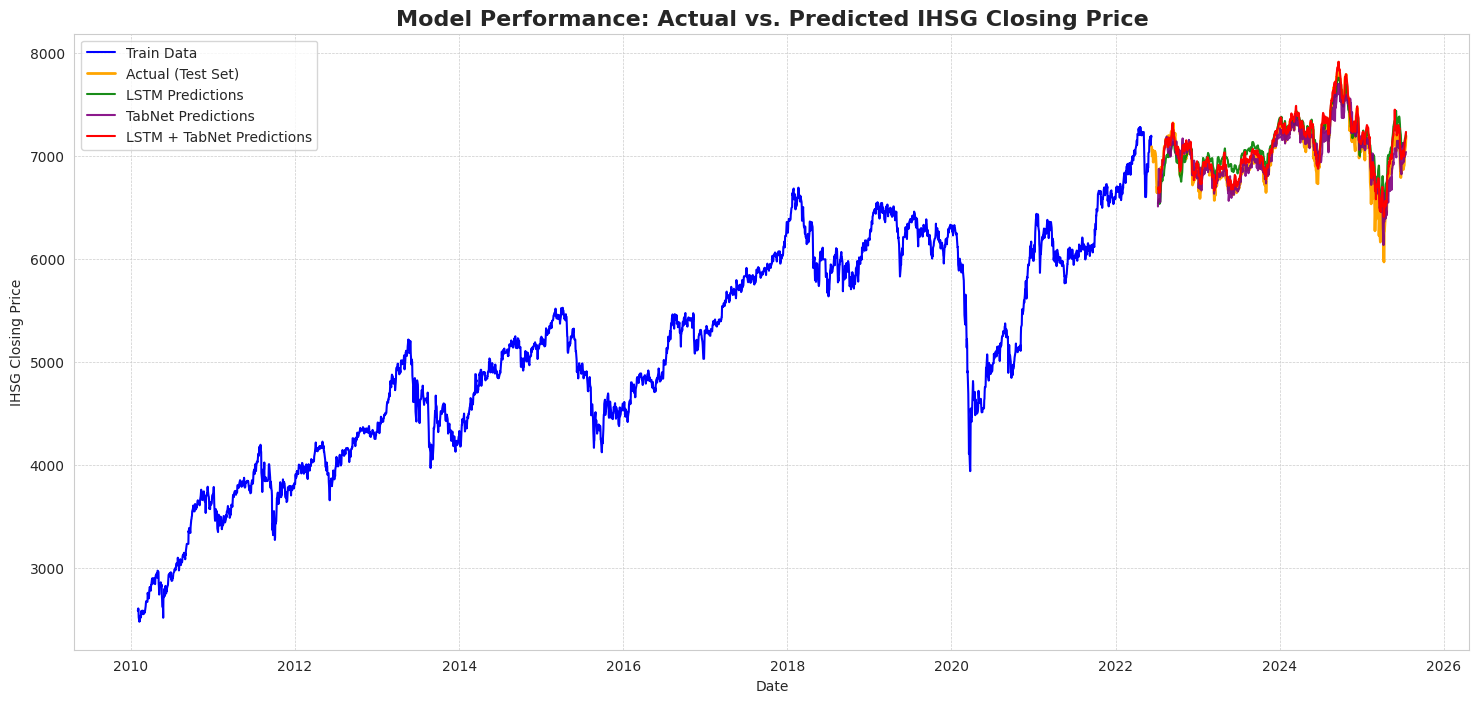

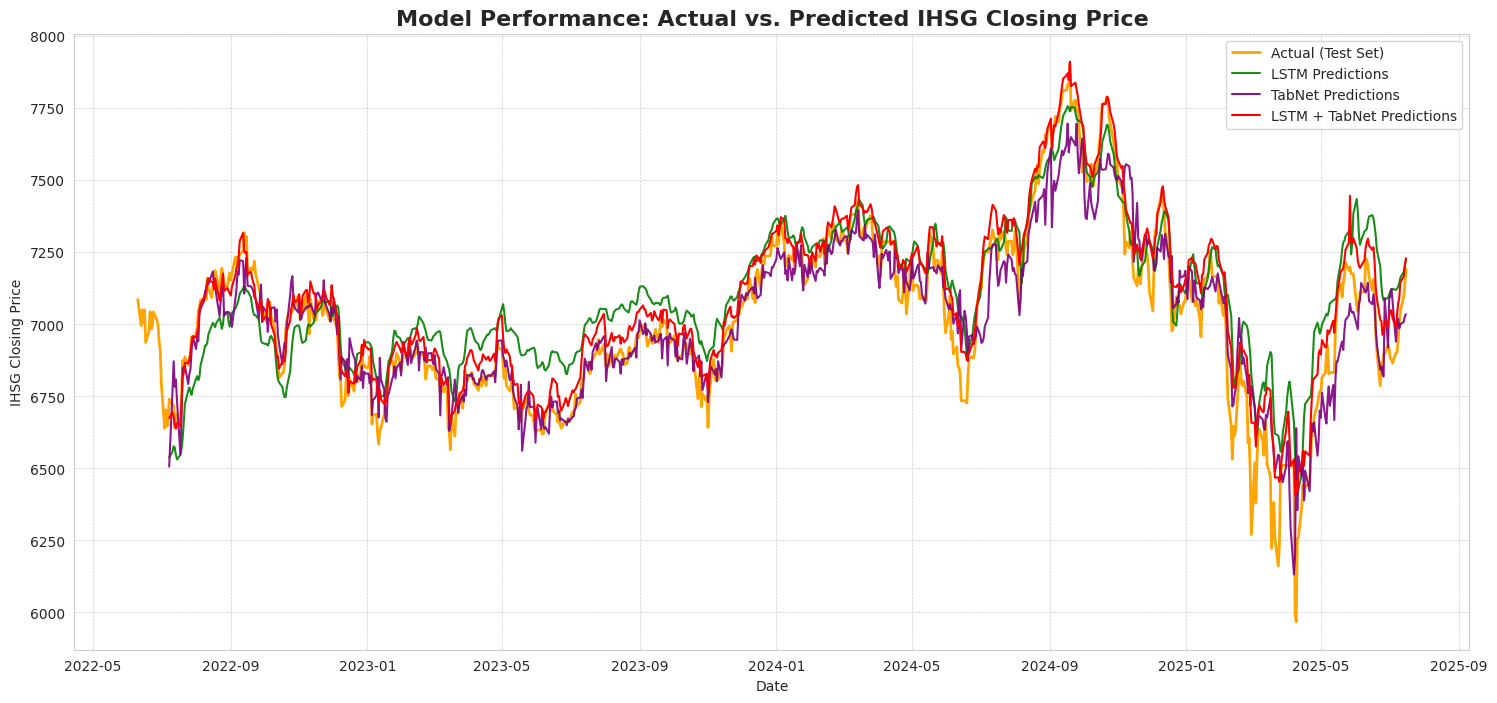

In [10]:
# ------------------------------
# 7. Reconstruct actual prices & Evaluate
# ------------------------------
final_pred = scaler_y.inverse_transform(final_pred_scaled.reshape(-1, 1)).flatten()
lstm_pred = scaler_y.inverse_transform(lstm_pred_test_scaled).flatten()
tabnet_pred = scaler_y.inverse_transform(tabnet_pred_test_scaled).flatten()
y_test_actual = y_test.iloc[TIME_STEPS:].values

def calculate_metrics(y_true, y_pred, model_name="Final Model"):
    metrics = {'Model': model_name, 'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)), 'MAE': mean_absolute_error(y_true, y_pred), 'R2': r2_score(y_true, y_pred), 'SMAPE (%)': 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true)/(np.abs(y_true) + np.abs(y_pred) + 1e-8))}
    return metrics

metrics_final = calculate_metrics(y_test_actual, final_pred, "Ensemble (LSTM+TabNet)")
metrics_lstm = calculate_metrics(y_test_actual, lstm_pred, "Standalone LSTM")
metrics_tabnet = calculate_metrics(y_test_actual, tabnet_pred, "TabNet")
results_df = pd.DataFrame([metrics_lstm, metrics_tabnet,metrics_final])

print("\n--- Final Combined Model Metrics ---")
print(results_df.to_string())

# --- REVISED PLOTTING LOGIC TO REMOVE GAP ---
train_data = data[:train_size]
valid_data = data[train_size:].copy()
prediction_dates = y_test.index[TIME_STEPS:]
valid_data['Predictions'] = np.nan
valid_data.loc[prediction_dates, 'Predictions'] = final_pred
valid_data['LSTM_Predictions'] = np.nan
valid_data.loc[prediction_dates, 'LSTM_Predictions'] = lstm_pred
valid_data['TabNet_Predictions'] = np.nan
valid_data.loc[prediction_dates, 'TabNet_Predictions'] = tabnet_pred


# Plotting
plt.figure(figsize=(18, 8))
plt.title('Model Performance: Actual vs. Predicted IHSG Closing Price', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('IHSG Closing Price')
plt.plot(train_data['IHSG'], label='Train Data', color='blue')
plt.plot(valid_data['IHSG'], label='Actual (Test Set)', color='orange', linewidth=2)
plt.plot(valid_data['LSTM_Predictions'], label='LSTM Predictions', color='green', alpha=0.9)
plt.plot(valid_data['TabNet_Predictions'], label='TabNet Predictions', color='purple', alpha=0.9)
plt.plot(valid_data['Predictions'], label='LSTM + TabNet Predictions', color='red')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# without the training data
plt.figure(figsize=(18, 8))
plt.title('Model Performance: Actual vs. Predicted IHSG Closing Price', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('IHSG Closing Price')
plt.plot(valid_data['IHSG'], label='Actual (Test Set)', color='orange', linewidth=2)
plt.plot(valid_data['LSTM_Predictions'], label='LSTM Predictions', color='green', alpha=0.9)
plt.plot(valid_data['TabNet_Predictions'], label='TabNet Predictions', color='purple', alpha=0.9)
plt.plot(valid_data['Predictions'], label='LSTM + TabNet Predictions', color='red')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()



Performing TabNet categorical analysis...

--- Top 15 Overall Feature Importance (TabNet) ---
                             Feature  Importance
31                        BBU_20_2.0    0.351043
32                        BBL_20_2.0    0.197492
45                 VIX_pct_change_1d    0.082369
26                      MACD_12_26_9    0.077647
30                        BBM_20_2.0    0.074831
2                            EUR/USD    0.032055
37            S&P 500_pct_change_10d    0.019117
28                     MACDh_12_26_9    0.018877
115                        DayOfYear    0.018778
7                                DAX    0.017869
81   Crude Oil (Brent)_pct_change_1d    0.015102
79                DAX_pct_change_10d    0.010697
91            EUR/USD_pct_change_10d    0.009782
29                            RSI_14    0.007386
76                 DAX_pct_change_2d    0.007224

--- Feature Importance by Category ---
           Category  Total_Importance
0         Technical          0.728463
1    

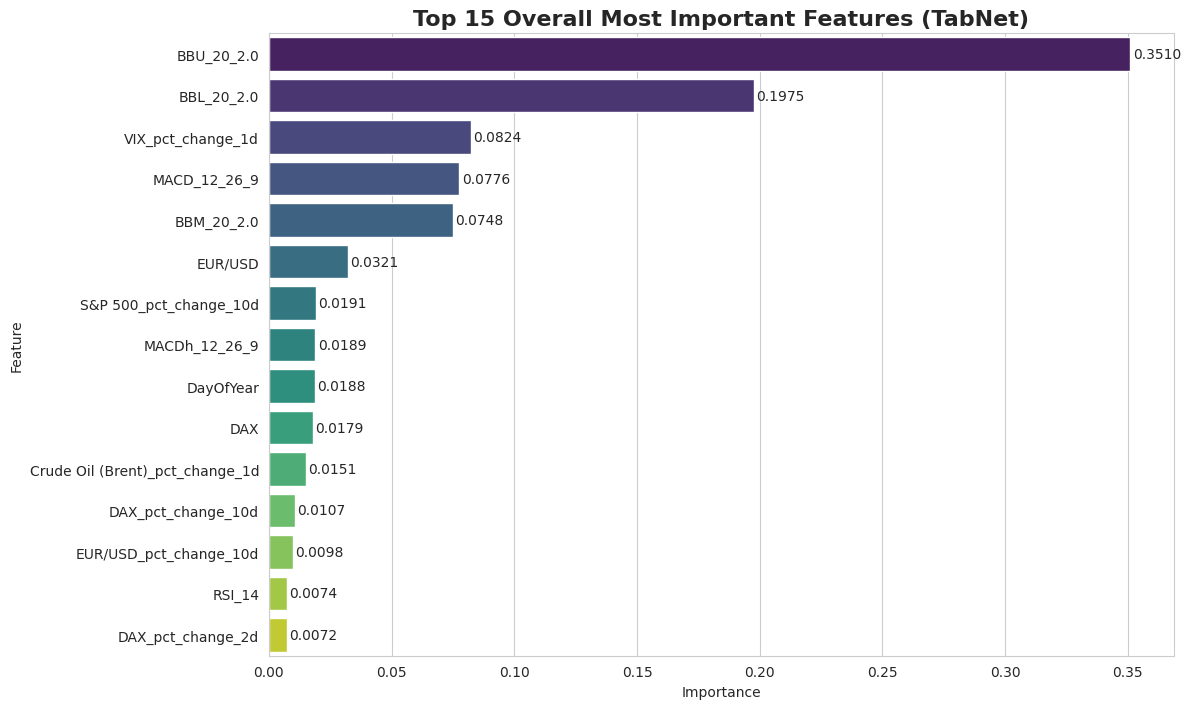

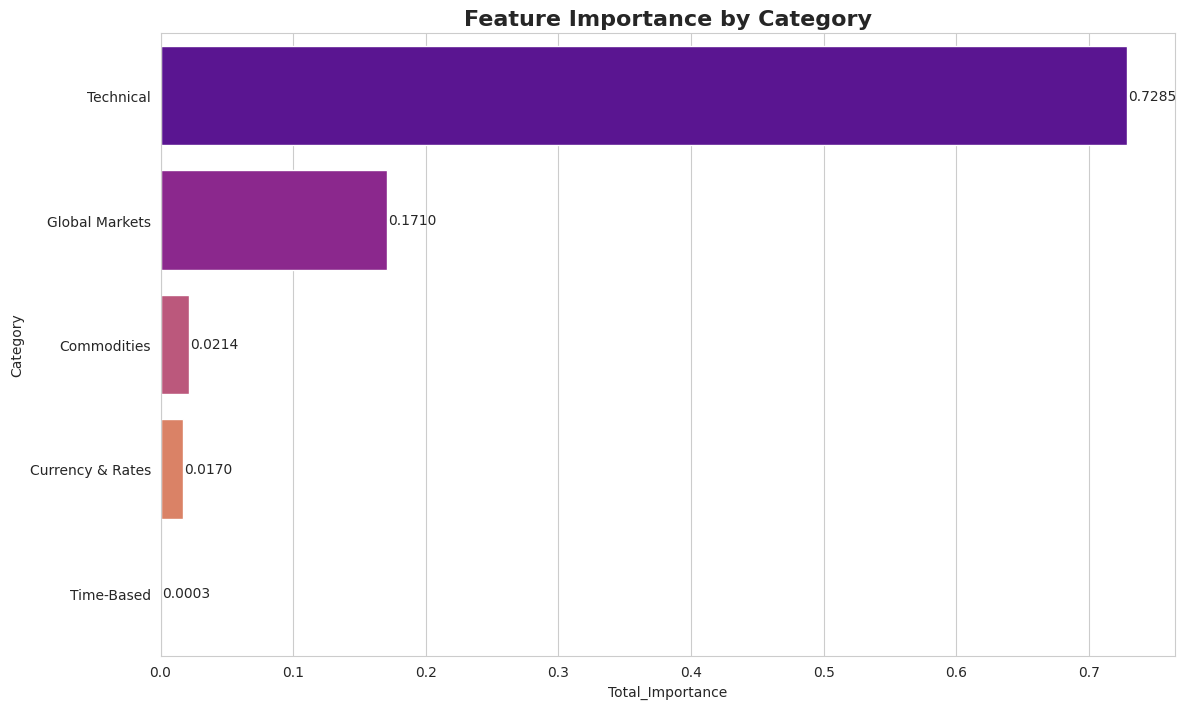

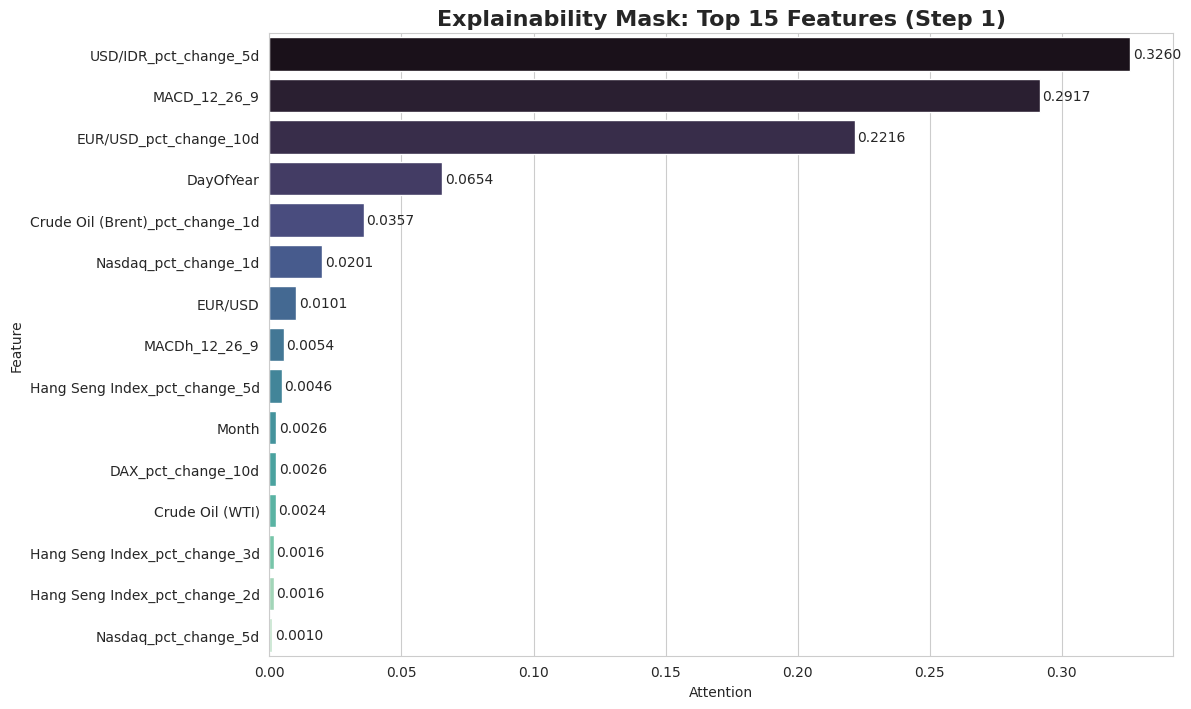

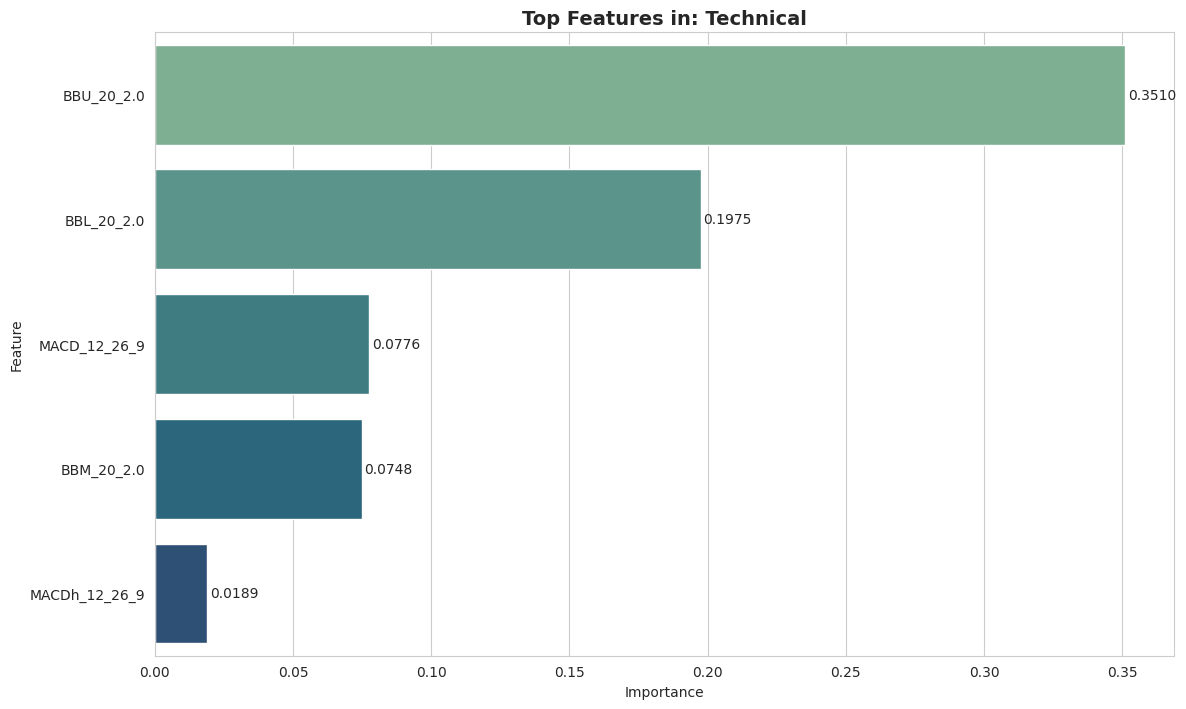

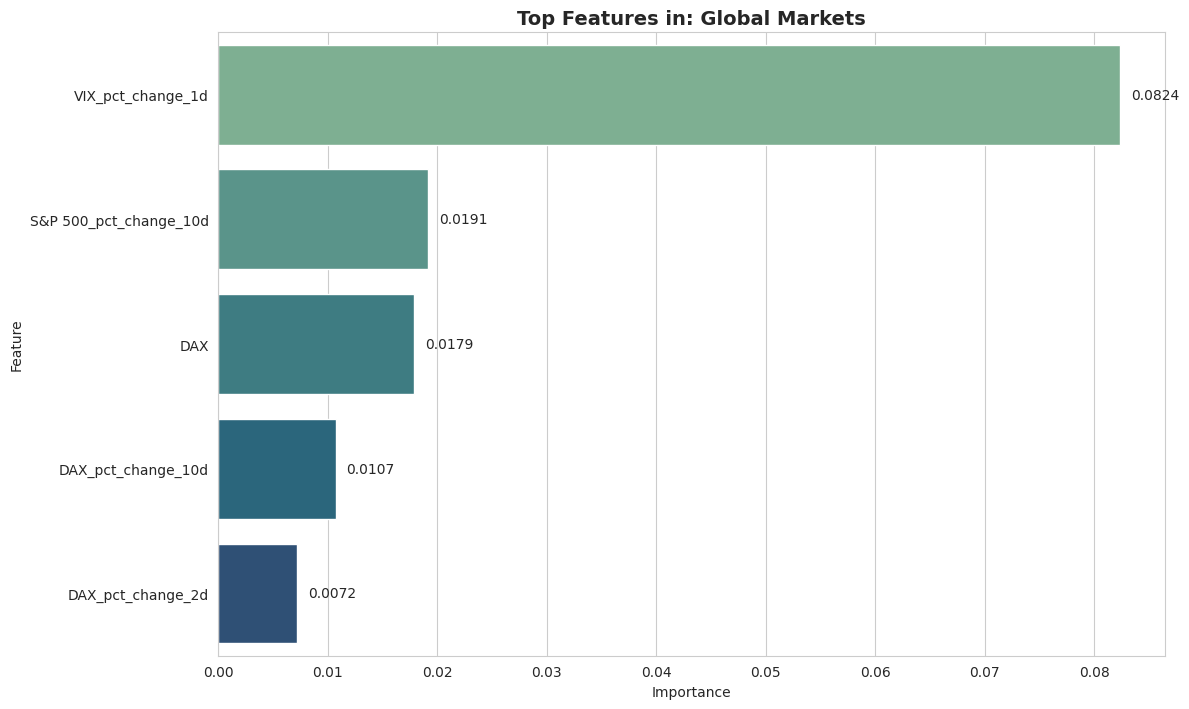

In [11]:
# ===================================================================
# 8. TabNet Feature Importance & Categorical Analysis (RESTORED)
# ===================================================================
print("\nPerforming TabNet categorical analysis...")

importance_df = pd.DataFrame({'Feature': features, 'Importance': final_tabnet.feature_importances_}).sort_values('Importance', ascending=False)

categories_map = {
    'Technical': [c for c in features if any(x in c for x in ['RSI', 'ATR', 'MACD', 'BBL', 'BBM', 'BBU'])],
    'Global Markets': [f for f in features if any(m in f for m in ['S&P 500', 'Nasdaq', 'DAX', 'VIX', 'Hang Seng'])],
    'Commodities': [f for f in features if any(m in f for m in ['Crude Oil', 'Gold', 'Copper', 'Silver'])],
    'Currency & Rates': [f for f in features if any(m in f for m in ['IDR', 'EURUSD', 'Federal Funds Rate'])],
    'Time-Based': ['DayOfWeek', 'Month', 'WeekOfYear']
}

category_importance = {}
for category, cat_features in categories_map.items():
    existing_features = [f for f in cat_features if f in importance_df['Feature'].values]
    category_importance[category] = importance_df[importance_df['Feature'].isin(existing_features)]['Importance'].sum()

category_df = pd.DataFrame(list(category_importance.items()), columns=['Category', 'Total_Importance']).sort_values('Total_Importance', ascending=False)

# --- ADDED: Print statements for the data behind the plots ---
print("\n--- Top 15 Overall Feature Importance (TabNet) ---")
print(importance_df.head(15).to_string())
print("\n--- Feature Importance by Category ---")
print(category_df.to_string())


# --- Visualization Dashboard (Each plot on its own figure) ---

# Define a consistent figure width based on the second image's aspect ratio
# Assuming the second image has a width that's good for a single plot
FIGURE_WIDTH = 12 # You can adjust this value as needed
FIGURE_HEIGHT_RATIO = 0.6 # Adjust height relative to width for better aspect ratio

# Plot 1: Overall Top 15 Features
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_WIDTH * FIGURE_HEIGHT_RATIO))
top_15_overall = importance_df.head(15)
ax1 = sns.barplot(data=top_15_overall, x='Importance', y='Feature', palette='viridis')
ax1.set_title('Top 15 Overall Most Important Features (TabNet)', fontsize=16, fontweight='bold')
# Add values to bars
for p in ax1.patches:
    width = p.get_width()
    ax1.text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')
plt.tight_layout()
plt.show()

# Plot 2: Importance by Category
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_WIDTH * FIGURE_HEIGHT_RATIO))
ax2 = sns.barplot(data=category_df, x='Total_Importance', y='Category', palette='plasma')
ax2.set_title('Feature Importance by Category', fontsize=16, fontweight='bold')
# Add values to bars
for p in ax2.patches:
    width = p.get_width()
    ax2.text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')
plt.tight_layout()
plt.show()

# --- UPDATED: Readable Explainability Mask Visualization ---
plt.figure(figsize=(FIGURE_WIDTH, FIGURE_WIDTH * FIGURE_HEIGHT_RATIO))
explain_matrix, masks = final_tabnet.explain(X_test_tabular)
# Get the attention scores for the first decision step and average them across all test samples
mask_step1_avg = np.mean(masks[0], axis=0)
mask_df = pd.DataFrame({'Feature': features, 'Attention': mask_step1_avg}).sort_values('Attention', ascending=False)
ax3 = sns.barplot(data=mask_df.head(15), x='Attention', y='Feature', palette='mako')
ax3.set_title('Explainability Mask: Top 15 Features (Step 1)', fontsize=16, fontweight='bold')
# Add values to bars
for p in ax3.patches:
    width = p.get_width()
    ax3.text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')
plt.tight_layout()
plt.show()


top_categories = category_df['Category'].head(2).tolist()

# Plot 4 & 5: Top Features in Top 2 Categories (each in its own figure)
for i, category in enumerate(top_categories):
    plt.figure(figsize=(FIGURE_WIDTH, FIGURE_WIDTH * FIGURE_HEIGHT_RATIO))
    cat_features = categories_map.get(category, [])
    cat_df = importance_df[importance_df['Feature'].isin(cat_features)].head(5)
    ax = sns.barplot(data=cat_df, x='Importance', y='Feature', palette='crest')
    ax.set_title(f'Top Features in: {category}', fontsize=14, fontweight='bold')
    # Add values to bars
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')
    plt.tight_layout()
    plt.show()